# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

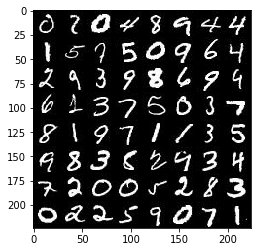

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

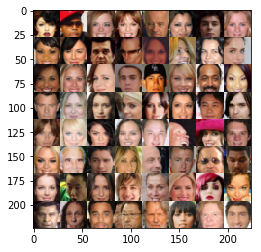

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs')
    real_z = tf.placeholder(tf.float32, (None, z_dim), name = 'real_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return real_inputs, real_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        keep_prob = 0.8
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        drop1 = tf.nn.dropout(relu1, keep_prob)
        
        layer2 = tf.layers.conv2d(drop1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob)
        
        layer3 = tf.layers.conv2d(drop2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob)
        
        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train = True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        layer1 = tf.reshape(x, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 1, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        layer4 = tf.layers.conv2d_transpose(relu3, 128, 1, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(layer4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        layer5 = tf.layers.conv2d_transpose(relu4, 64, 5, strides=2, padding='same')
        bn5 = tf.layers.batch_normalization(layer5, training=is_train)
        relu5 = tf.maximum(alpha * bn5, bn5)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu5, out_channel_dim, 1, strides=1, padding='same')
        # 28x28x3 
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    discriminator_loss = d_loss_real + d_loss_fake
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
   
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train = tf.trainable_variables()
    discriminator_var = [x for x in train if x.name.startswith('discriminator')]
    generator_var = [x for x in train if x.name.startswith('generator')]
    
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [op for op in update if op.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(generator_updates):
        discrimiator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_var)
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_var)
    
    return discrimiator_opt, generator_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    real_inputs, real_z, learning_rate_in = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, real_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ real_inputs: batch_images, real_z: batch_z, learning_rate_in: learning_rate })
                _ = sess.run(g_opt, feed_dict={ real_z: batch_z, learning_rate_in: learning_rate })
                
                if steps % print_every == 0:
                    d_loss_train = d_loss.eval({
                        real_z: batch_z,
                        real_inputs: batch_images
                    })
                    g_loss_train = g_loss.eval({
                        real_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, real_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 2.4430
Epoch 1/2... Discriminator Loss: 0.3904... Generator Loss: 4.4620
Epoch 1/2... Discriminator Loss: 0.3913... Generator Loss: 4.5721
Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 4.8783
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 6.2873
Epoch 1/2... Discriminator Loss: 0.3607... Generator Loss: 6.3892
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 6.8676
Epoch 1/2... Discriminator Loss: 0.4021... Generator Loss: 4.9166
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 2.2354
Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 6.7735


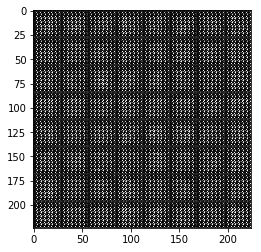

Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 9.1381
Epoch 1/2... Discriminator Loss: 0.3586... Generator Loss: 6.9071
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 6.8108
Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 6.7755
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 6.8494
Epoch 1/2... Discriminator Loss: 0.3551... Generator Loss: 7.8411
Epoch 1/2... Discriminator Loss: 0.3466... Generator Loss: 8.0406
Epoch 1/2... Discriminator Loss: 0.3484... Generator Loss: 7.7616
Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 6.5767
Epoch 1/2... Discriminator Loss: 0.3403... Generator Loss: 6.7921


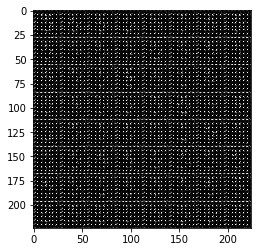

Epoch 1/2... Discriminator Loss: 0.3462... Generator Loss: 6.5856
Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 7.0698
Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 6.9065
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 7.2956
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 7.2396
Epoch 1/2... Discriminator Loss: 0.3524... Generator Loss: 6.6089
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 7.5391
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 6.9918
Epoch 1/2... Discriminator Loss: 0.3447... Generator Loss: 7.1582
Epoch 1/2... Discriminator Loss: 0.3368... Generator Loss: 7.6772


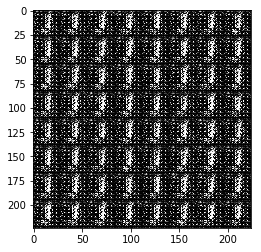

Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 8.1385
Epoch 1/2... Discriminator Loss: 0.3396... Generator Loss: 7.5786
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 7.9204
Epoch 1/2... Discriminator Loss: 0.3434... Generator Loss: 7.9878
Epoch 1/2... Discriminator Loss: 0.3383... Generator Loss: 7.7570
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 8.2203
Epoch 1/2... Discriminator Loss: 0.3386... Generator Loss: 7.8915
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 7.9237
Epoch 1/2... Discriminator Loss: 0.3382... Generator Loss: 7.8556
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 7.8105


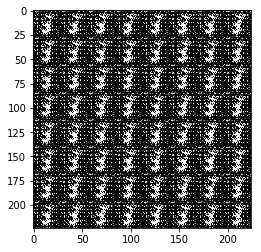

Epoch 1/2... Discriminator Loss: 0.3425... Generator Loss: 8.3636
Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 8.1191
Epoch 1/2... Discriminator Loss: 0.3374... Generator Loss: 8.0851
Epoch 1/2... Discriminator Loss: 0.3370... Generator Loss: 8.5191
Epoch 1/2... Discriminator Loss: 0.3374... Generator Loss: 8.2980
Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 8.3175
Epoch 1/2... Discriminator Loss: 0.3363... Generator Loss: 8.9212
Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 8.4068
Epoch 1/2... Discriminator Loss: 0.3383... Generator Loss: 8.3207
Epoch 1/2... Discriminator Loss: 0.3342... Generator Loss: 8.3412


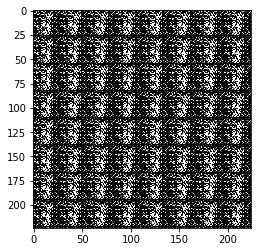

Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 8.3580
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 8.6513
Epoch 1/2... Discriminator Loss: 0.3342... Generator Loss: 8.6887
Epoch 1/2... Discriminator Loss: 0.3438... Generator Loss: 8.8165
Epoch 1/2... Discriminator Loss: 0.3368... Generator Loss: 8.2491
Epoch 1/2... Discriminator Loss: 0.3362... Generator Loss: 8.5331
Epoch 1/2... Discriminator Loss: 0.3347... Generator Loss: 8.8194
Epoch 1/2... Discriminator Loss: 0.3339... Generator Loss: 8.8387
Epoch 1/2... Discriminator Loss: 0.3366... Generator Loss: 8.5048
Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 8.6780


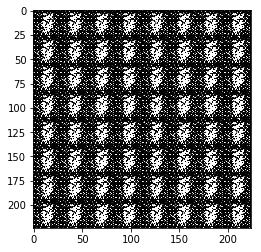

Epoch 1/2... Discriminator Loss: 0.3343... Generator Loss: 8.6866
Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 8.2111
Epoch 1/2... Discriminator Loss: 0.3350... Generator Loss: 8.7335
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 8.9728
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 8.7687
Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 8.6206
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 8.3197
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 8.6988
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 8.6853
Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 8.7904


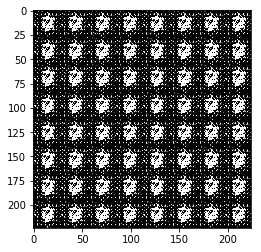

Epoch 1/2... Discriminator Loss: 0.3383... Generator Loss: 9.1781
Epoch 1/2... Discriminator Loss: 0.3321... Generator Loss: 8.6539
Epoch 1/2... Discriminator Loss: 0.3321... Generator Loss: 8.6725
Epoch 1/2... Discriminator Loss: 0.3337... Generator Loss: 8.8808
Epoch 1/2... Discriminator Loss: 0.3326... Generator Loss: 8.5622
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 8.4643
Epoch 1/2... Discriminator Loss: 0.3370... Generator Loss: 8.8316
Epoch 1/2... Discriminator Loss: 0.3331... Generator Loss: 8.8473
Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 9.0933
Epoch 1/2... Discriminator Loss: 0.3323... Generator Loss: 9.1054


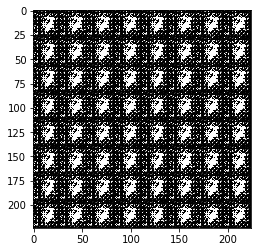

Epoch 1/2... Discriminator Loss: 0.3329... Generator Loss: 9.1010
Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 9.3046
Epoch 1/2... Discriminator Loss: 0.3370... Generator Loss: 8.6824
Epoch 1/2... Discriminator Loss: 0.3337... Generator Loss: 9.0668
Epoch 1/2... Discriminator Loss: 0.3344... Generator Loss: 9.1988
Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 9.0246
Epoch 1/2... Discriminator Loss: 0.3338... Generator Loss: 9.2486
Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 9.1745
Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 9.1573
Epoch 1/2... Discriminator Loss: 0.3323... Generator Loss: 9.2881


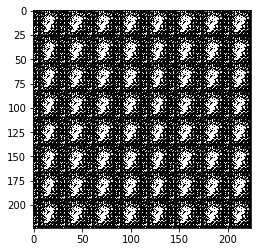

Epoch 1/2... Discriminator Loss: 0.3318... Generator Loss: 9.4946
Epoch 1/2... Discriminator Loss: 0.3358... Generator Loss: 9.5042
Epoch 1/2... Discriminator Loss: 0.3313... Generator Loss: 9.3627
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 9.0134
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 9.0239
Epoch 2/2... Discriminator Loss: 0.3314... Generator Loss: 9.3551
Epoch 2/2... Discriminator Loss: 0.3314... Generator Loss: 9.3566
Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 9.2736
Epoch 2/2... Discriminator Loss: 0.3326... Generator Loss: 9.3117
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 9.4346


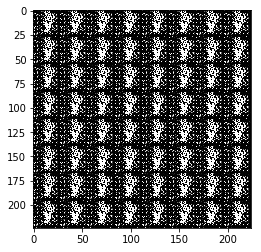

Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 9.5061
Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 8.9583
Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 9.1535
Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 9.2203
Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 9.1485
Epoch 2/2... Discriminator Loss: 0.3326... Generator Loss: 9.0624
Epoch 2/2... Discriminator Loss: 0.3337... Generator Loss: 9.0038
Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 9.2927
Epoch 2/2... Discriminator Loss: 0.3322... Generator Loss: 9.5120
Epoch 2/2... Discriminator Loss: 0.3303... Generator Loss: 9.2581


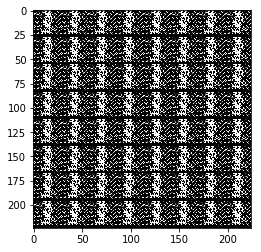

Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 9.5890
Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 9.3054
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 9.4805
Epoch 2/2... Discriminator Loss: 0.3307... Generator Loss: 9.2988
Epoch 2/2... Discriminator Loss: 0.3325... Generator Loss: 9.3029
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 9.3751
Epoch 2/2... Discriminator Loss: 0.3314... Generator Loss: 9.7491
Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 9.9531
Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 9.5930
Epoch 2/2... Discriminator Loss: 0.3318... Generator Loss: 9.5395


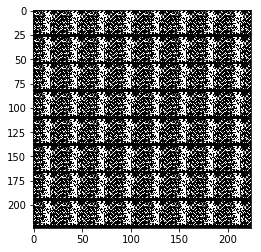

Epoch 2/2... Discriminator Loss: 0.3297... Generator Loss: 9.5260
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 9.7630
Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 9.3175
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 9.5266
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 9.4315
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 9.3208
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 9.5642
Epoch 2/2... Discriminator Loss: 0.3297... Generator Loss: 9.6182
Epoch 2/2... Discriminator Loss: 0.3305... Generator Loss: 9.7162
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 8.9900


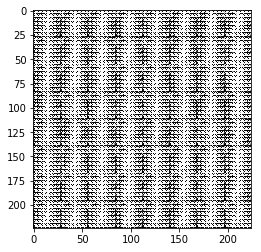

Epoch 2/2... Discriminator Loss: 0.3945... Generator Loss: 4.0512
Epoch 2/2... Discriminator Loss: 0.8106... Generator Loss: 2.5507
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 1.4536
Epoch 2/2... Discriminator Loss: 0.3756... Generator Loss: 4.7053
Epoch 2/2... Discriminator Loss: 0.3592... Generator Loss: 5.2170
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 3.4453
Epoch 2/2... Discriminator Loss: 0.7057... Generator Loss: 1.7695
Epoch 2/2... Discriminator Loss: 0.4865... Generator Loss: 3.4884
Epoch 2/2... Discriminator Loss: 0.6073... Generator Loss: 3.0158
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 4.3995


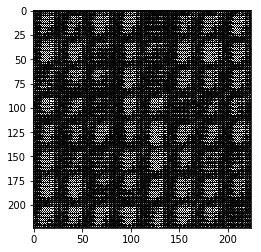

Epoch 2/2... Discriminator Loss: 0.3870... Generator Loss: 5.9002
Epoch 2/2... Discriminator Loss: 0.3932... Generator Loss: 4.4894
Epoch 2/2... Discriminator Loss: 0.3976... Generator Loss: 4.3912
Epoch 2/2... Discriminator Loss: 2.4194... Generator Loss: 0.1971
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.4692
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.4628
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 1.4457
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 1.9958
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 1.6040
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 1.4198


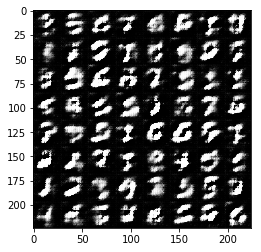

Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 1.7614
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 1.6628
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 2.4051
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 1.2062
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 1.5471
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 1.0198
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 1.4554
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.4181


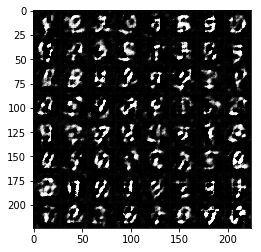

Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 1.4135
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 1.8114
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.7530
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 2.2181
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 1.6363
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 1.5999
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.9876


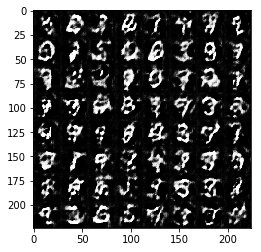

Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.2329
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 1.0306
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 1.1264
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.7027


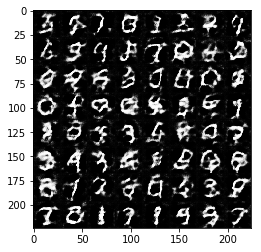

Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 2.1586
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.3432
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 1.3415
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 2.1688
Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.8308


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 3.4693
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.7042
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 5.0617
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 4.0462
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 4.3043
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 5.1029
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 4.8351
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 5.3987
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 7.0399
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 5.6909


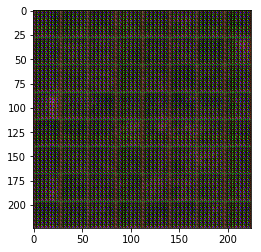

Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 5.2733
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 5.3275
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 6.2046
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 3.2004
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 6.2577
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 7.2701
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 4.5214
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 3.1629
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 4.4232
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 7.1633


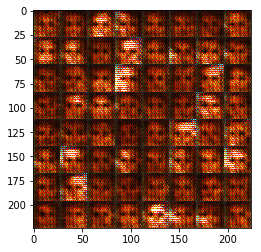

Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 2.3216
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.2103
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 2.8843
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.7261
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.0357


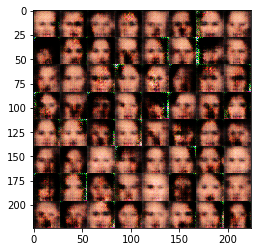

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9167


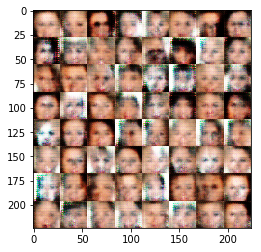

Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.8526
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 1.0543


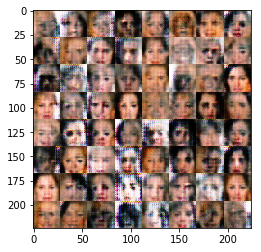

Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.8972


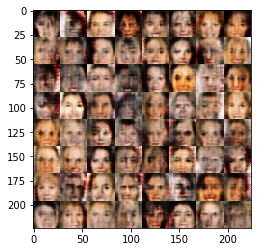

Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9152


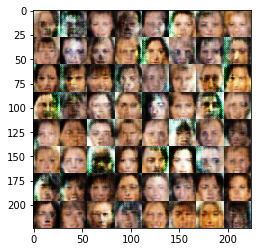

Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9918


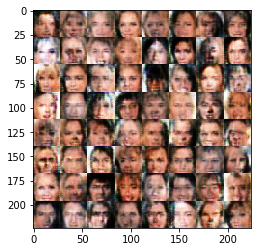

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.0816


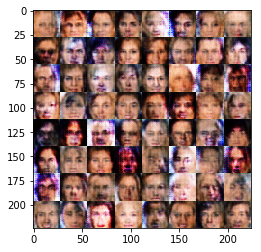

Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.9522


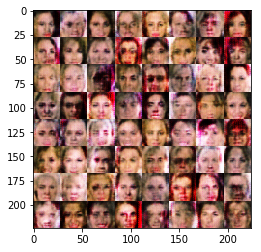

Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.9161


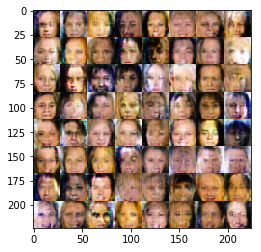

Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.2399


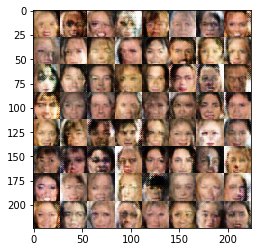

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8227


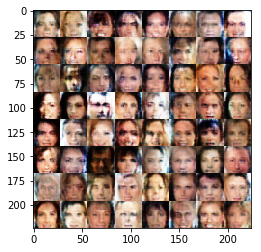

Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9518


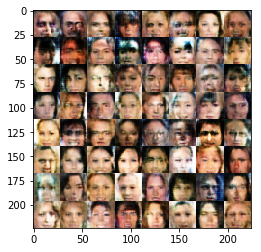

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.5083
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.8315


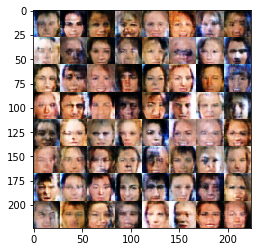

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.9654


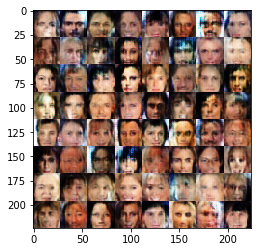

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8263


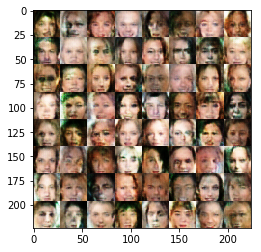

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7318


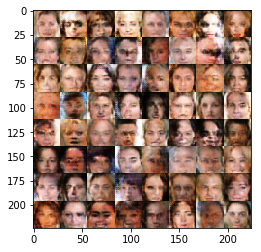

Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.9383


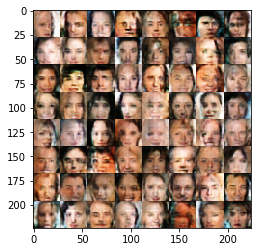

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.2102


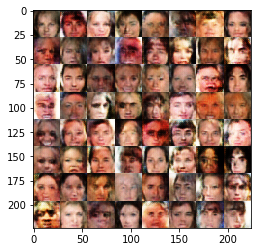

Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8148


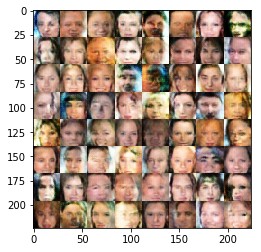

Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.0972


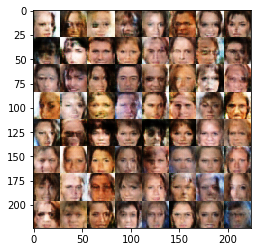

Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8954


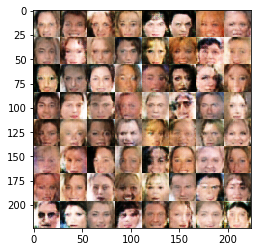

Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.9533


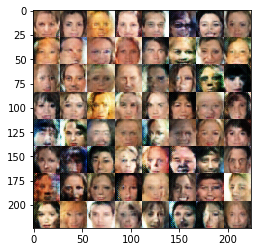

Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0795


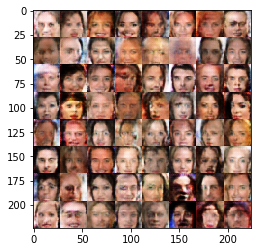

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 1.1712


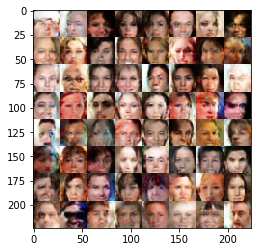

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7639


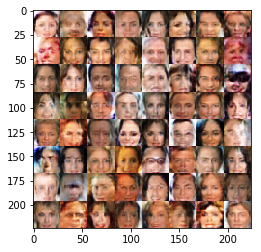

Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7442


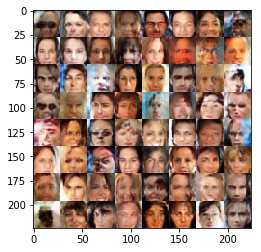

Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6929


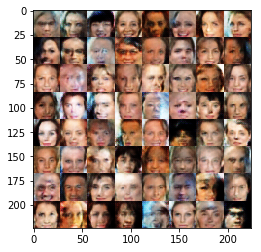

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.0234


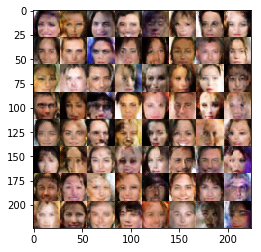

Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1510


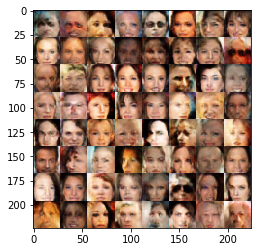

Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.9573


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.